<a href="https://colab.research.google.com/github/amirmahdiansaripour/Artificial-Inteligence-Assigments/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from PIL import Image
import os
from pathlib import Path

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Dense,
                                     BatchNormalization,
                                     LeakyReLU,
                                     Reshape,
                                     Conv2DTranspose,
                                     Conv2D,
                                     Dropout,
                                     Flatten)
import matplotlib.pyplot as plt

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
@tf.function
def train_step(images, batch_size):

    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss,
                                               generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,
                                                discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
import time
from IPython import display # A command shell for interactive computing in Python.

def train(dataset, epochs, batch_size):
  for epoch in range(epochs):
    start = time.time()
    for image_batch in dataset:
      train_step(image_batch, batch_size)
  print("minimax loss obtained")
  display.clear_output(wait=True)

In [ ]:
output_images = {}
inference_exe_time = []

def generate_and_save_images(model, test_input, epoch, batch_size, input_index, save, show):
  predictions = model(test_input, training=False)
  path_to_save = "/content/gdrive/MyDrive/Machine Learning Course Projects"
  if output_images.get((epoch, batch_size)) == None:
    output_images[(epoch, batch_size)] = predictions
  else:
    if input_index < 8:
      curr = output_images.get((epoch, batch_size))
      output_images[(epoch, batch_size)] = tf.concat(axis=0, values = [curr, predictions])

  if save == True:
    for i in range(predictions.shape[0]):
        plt.imshow(predictions[i, :, :, 0] * 200 + 200, cmap='gray')
        plt.axis('off')
        image_name = path_to_save + '/'+str(epoch)+"_"+str(batch_size)+"_label_"+str(i)+"_"+ str(input_index) +".png"
        plt.savefig(image_name)
  if show == True:
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 200 + 200, cmap='gray')
        plt.axis('off')
    plt.show()
    plt.close(fig)

In [ ]:
import numpy

def plot_inference_exe_time(inference_exe_time):
  target = []
  for t in inference_exe_time:
    if t > 0.05:
      target.append(t)

  plt.title("Inference execution times")
  plt.scatter(numpy.arange(0,len(target)), target)

In [ ]:
BATCH_SIZE = 128
BUFFER_SIZE = 60000
EPOCHS = 20
num_examples_to_generate = 16
noise_dim = 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder = True)

In [ ]:
start_time = time.time()
train(train_dataset, BATCH_SIZE, EPOCHS)
end_time = time.time()
train_time = end_time - start_time
print("Training time: ", train_time)

Training time:  574.85009598732


In [ ]:
def inference_step(epochs, batch_size, index, save, show):
  start_time = time.time()
  tf.random.set_seed(index)
  generate_and_save_images(generator, tf.random.normal([num_examples_to_generate, noise_dim]),
                           epochs, batch_size, index, save, show)
  end_time = time.time()
  exe_time = end_time - start_time
  inference_exe_time.append(exe_time)
  if show == True:
    print("Outputs for ", epochs , " number of epochs and " , batch_size, " batch size")
  if show == True:
    print("execution time: " , exe_time)

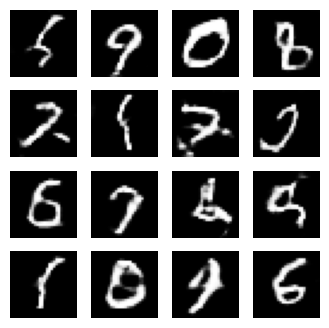

Outputs for  20  number of epochs and  128  batch size
execution time:  0.4157397747039795


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 1, False, True)

In [ ]:
abc = output_images.get((20, 128))
print(abc.shape)

(16, 28, 28, 1)


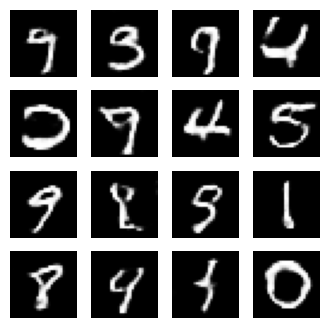

Outputs for  20  number of epochs and  128  batch size
execution time:  0.41333794593811035


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 2, False, True)

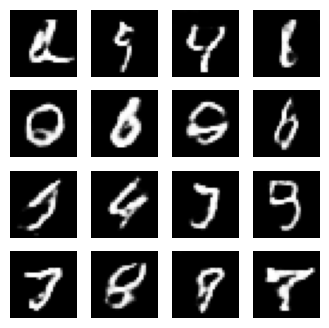

Outputs for  20  number of epochs and  128  batch size
execution time:  0.7274022102355957


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 3, False, True)

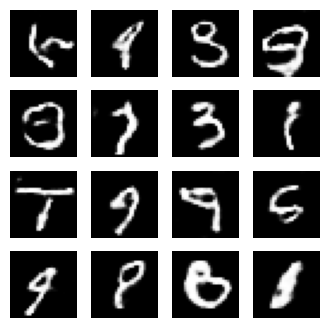

Outputs for  20  number of epochs and  128  batch size
execution time:  2.50191330909729


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 4, False, True)

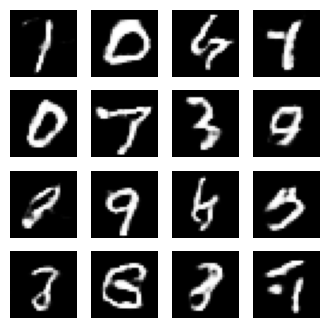

Outputs for  20  number of epochs and  128  batch size
execution time:  0.5814657211303711


In [ ]:
inference_step(EPOCHS, BATCH_SIZE, 5, False, True)

In [ ]:
for i in range(1,100,1):
  inference_step(EPOCHS, BATCH_SIZE, 5+i, False, False)

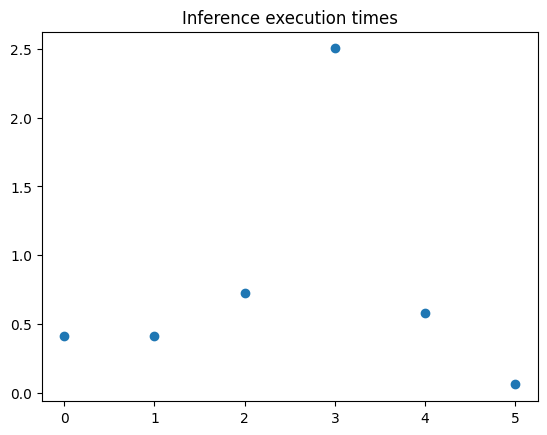

In [ ]:
plot_inference_exe_time(inference_exe_time)

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import shuffle
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
from keras.datasets import cifar10


In [ ]:
def scale_images(images, new_shape):
  scaled_images = list()
  for image in images:
    new_image = resize(image, new_shape, 0)
    scaled_images.append(new_image)
  return asarray(scaled_images)

In [ ]:
def calculate_fid(model, images1, images2):
	out1 = model.predict(images1)
	out2 = model.predict(images2)
	mu1, sigma1 = out1.mean(axis=0), cov(out1, rowvar=False)
	mu2, sigma2 = out2.mean(axis=0), cov(out2, rowvar=False)
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	covmean = sqrtm(sigma1.dot(sigma2))
	if iscomplexobj(covmean):
		covmean = covmean.real
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

In [ ]:
train_set_numpy = numpy.stack(list(train_dataset))
test_images = output_images.get((20, 128))
test_images = tf.data.Dataset.from_tensor_slices(test_images)
test_set_numpy = numpy.stack(list(test_images))

In [ ]:
print((train_set_numpy.shape))
print((test_set_numpy.shape))

(468, 128, 28, 28, 1)
(112, 28, 28, 1)


In [ ]:
train_set_numpy = train_set_numpy.astype('float32')
test_set_numpy = test_set_numpy.astype('float32')

train_set_resized = list()
for photo in train_set_numpy:
    m,n,z = photo.shape[-3:]
    photo = photo.flat[:m*n*z].reshape(m,n,z)
    train_set_resized.append(photo)
train_set_resized = numpy.array(train_set_resized)

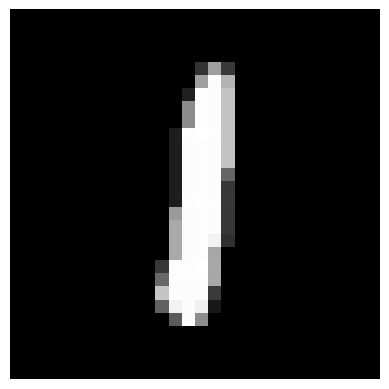

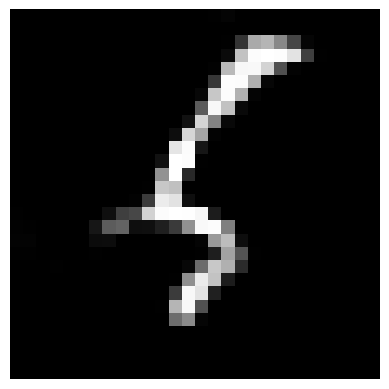

In [ ]:
plt.imshow(train_set_resized[0], cmap='gray')
plt.axis('off')
plt.show()

plt.imshow(test_set_numpy[0], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# resize images
train_set_resized = scale_images(train_set_resized, (299,299,3))
test_set_resized = scale_images(test_set_numpy, (299,299,3))
print('Scaled', train_set_resized.shape, test_set_resized.shape)
# pre-process images
images1 = preprocess_input(train_set_resized)
images2 = preprocess_input(test_set_resized)
# calculate fid
fid = calculate_fid(model, train_set_resized, test_set_resized)
print('FID: %.3f' % fid)

Scaled (468, 299, 299, 3) (112, 299, 299, 3)
4/4 [==============================] - 0s 106ms/step
FID: 7815949715471316982416191426114913627106271522766888529713864353259191635581416899847190266624510243690279600128.000
